In [163]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import time

In [164]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

In [165]:
X = sigmax()
Z = sigmaz()
Y = sigmay()
I = qeye(2)

# [[4, 2, 2]]-stabilizer

In [166]:
S_X = tensor(X, X, X, X)
S_Z = tensor(Z, Z, Z, Z)

X_L_1 = tensor(X, I, X, I)
Z_L_1 = tensor(Z, Z, I, I)

X_L_2 = tensor(X, X, I, I)
Z_L_2 = tensor(Z, I, Z, I)

G = [tensor(X,X,I,I), 
     tensor(Z,I,Z,I),
     tensor(I,I,X,X),
     tensor(I,Z,I,Z)]

Text(0.5, 1.0, 'Pulses over time')

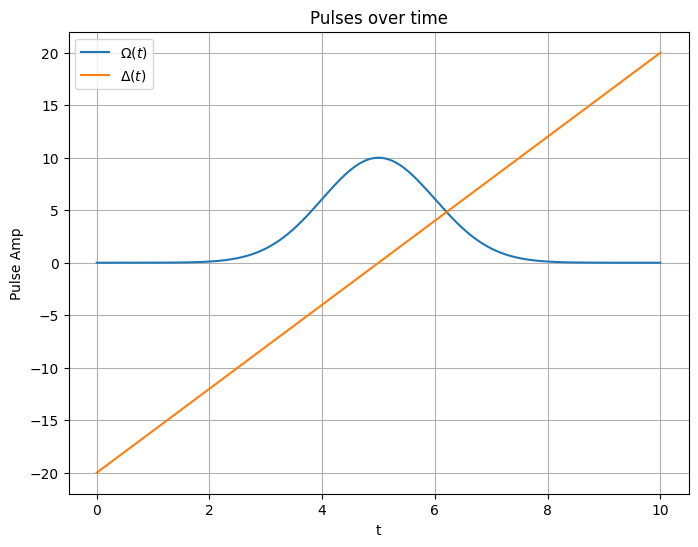

In [167]:
# defining time dependant coefs
T = 10
t = np.linspace(0, T, 1000)
sigma = 1
omega_max = 10
omega_t = omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 2*omega_max*(t / (T/2) - 1)

# Plot the wave
plt.figure(figsize=(8, 6))
plt.plot(t, omega_t, label=r'$\Omega(t)$')
plt.plot(t, delta_t, label=r'$\Delta(t)$')
plt.xlabel("t")
plt.ylabel("Pulse Amp")
plt.grid(True)
plt.legend()
plt.title("Pulses over time")


In [168]:
T = 20
times = np.linspace(0, T, 100)
sigma = 1
omega_max = 10
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = lambda t: 2*omega_max*(t / (T/2) - 1)


|ψ⟩ = 0.50|0000⟩ + 0.50|0101⟩ + 0.50|1010⟩ + 0.50|1111⟩


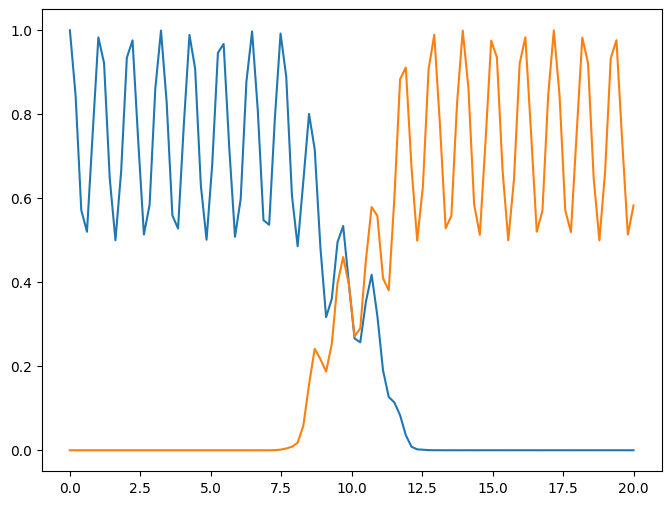

In [179]:
logical_zero = (tensor(basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0)) + 
                tensor(basis(2, 1), basis(2, 1), basis(2, 1), basis(2, 1))).unit()

zero_state = tensor(basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0))

logical_one = X_L_1 * logical_zero

logical_plus = (logical_zero + logical_one).unit()


print_quantum_state_as_superposition(logical_plus)
                                     
e_ops = [logical_zero*logical_zero.dag(), logical_one*logical_one.dag()]

Ep = 100
lambda1 = 1
lambda2 = 1
nu1 = 1
nu2 = 1
x = 1
z = 1
opt = 'gauge'

X_A = tensor(X, X, I, I)
Z_A = tensor(Z, I, Z, I)
def H_supp(x, z, nu1, nu2, lambda1, lambda2, opt):
    H_supp_stab = S_X + S_Z
    H_supp_gauge = -(lambda1 + lambda2*x) * X_A -(nu1 + nu2*z) * Z_A
    # H_supp_gauge = -sum(G)
    # H_supp_gauge = -(X_A + Z_A)
    if opt == 'stab':
        return H_supp_stab
    elif opt == 'gauge':
        return H_supp_gauge
    else:
        raise ValueError

def H_L(t):
    return X_L_1 * omega_t(t) + Z_L_1 * delta_t(t) + Ep * H_supp(x, z, nu1, nu2, lambda1, lambda2, opt)

results = sesolve(H_L, logical_zero, times, e_ops=e_ops)

plt.figure(figsize=(8, 6))
plt.plot(times, results.expect[0], label=r"$\rho_0$")
plt.plot(times, results.expect[1], label=r"$\rho_1$")
plt.show()

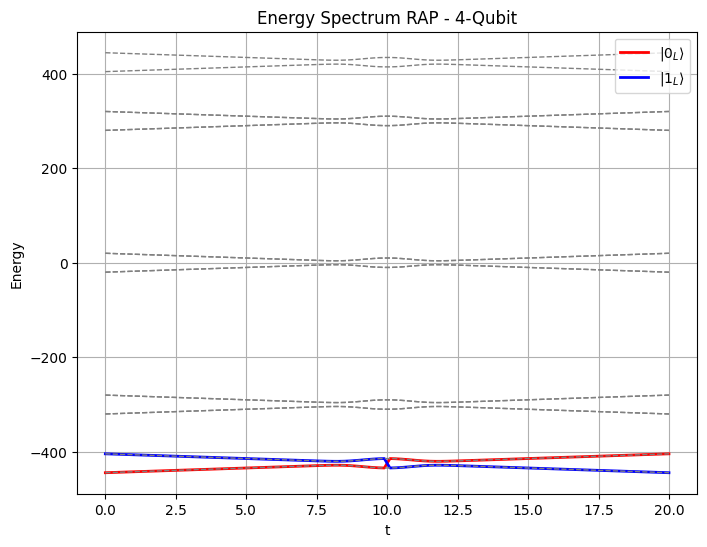

In [191]:
# Calculate the initial Hamiltonian eigenstates
lambda1 = 10
lambda2 = 1
nu1 = 1
nu2 = 1
x = 1
z = 1
Ep = 150

def H_test(t, x, z, nu1, nu2, lambda1, lambda2):
    # return X_L_1 * omega_t(t) + Z_L_1 * delta_t(t) + Ep * H_supp(x, z, nu1, nu2, lambda1, lambda2, opt)
    return X_L_1 * omega_t(t) + Z_L_1 * delta_t(t) - Ep * sum(G)
    

H_S_0 = H_test(0, x, z, nu1, nu2, lambda1, lambda2)
eigenvalues_0, eigenstates_0 = H_S_0.eigenstates()

# Logical state overlaps initialization
logical_zero_energies = []
logical_one_energies = []
other_energies = []

# Loop through time steps
for t_step in range(len(times)):
    H_S = H_test(times[t_step],  x, z, nu1, nu2, lambda1, lambda2)
    eigenvalues, eigenstates = H_S.eigenstates()

    # Track energies for logical states
    max_overlap_zero = 0
    max_overlap_one = 0
    zero_energy = None
    one_energy = None

    for i, state_t in enumerate(eigenstates):
        overlap_zero = np.abs(logical_zero.overlap(state_t))**2
        overlap_one = np.abs(logical_one.overlap(state_t))**2
        
        if overlap_zero > max_overlap_zero:
            max_overlap_zero = overlap_zero
            zero_energy = eigenvalues[i]

        if overlap_one > max_overlap_one:
            max_overlap_one = overlap_one
            one_energy = eigenvalues[i]

    logical_zero_energies.append(zero_energy)
    logical_one_energies.append(one_energy)

    # Store all other energies
    other_energies.append([eigenvalues[i] for i in range(len(eigenvalues)) if i != zero_energy and i != one_energy])

# Plotting
plt.figure(figsize=(8, 6))

# Plot logical states
plt.plot(times, logical_zero_energies, color='red', linewidth=2, label=r"$|0_L\rangle$")
plt.plot(times, logical_one_energies, color='blue', linewidth=2, label=r"$|1_L\rangle$")

# Plot all other energies
for i in range(len(other_energies[0])):
    plt.plot(times, [other_energies[t][i] for t in range(len(times))], linestyle='dashed', color='gray', linewidth=1)

# Finalize the plot
plt.xlabel('t')
plt.ylabel('Energy')
plt.title(r'Energy Spectrum RAP - 4-Qubit')
plt.legend(loc='upper right')
plt.grid()
plt.show()


In [28]:
logical_zero = (tensor([basis(2, 0) for _ in range(4)]) + tensor([basis(2, 1) for _ in range(4)])).unit()
logical_one = X_L_1 * logical_zero

X_A = tensor(X, X, I, I)
Z_A = tensor(Z, I, Z, I)
lambda1 = 1
lambda2 = 1
nu1 = 1
nu2 = 1
x = -1
z = -1

Ep = 20
H_supp = -(lambda1 + lambda2*x) * X_A -(nu1 + nu2*z) * Z_A

def H_L(t):
    return X_L_1 * omega_t(t) + Z_L_1 * delta_t(t) + Ep * H_supp


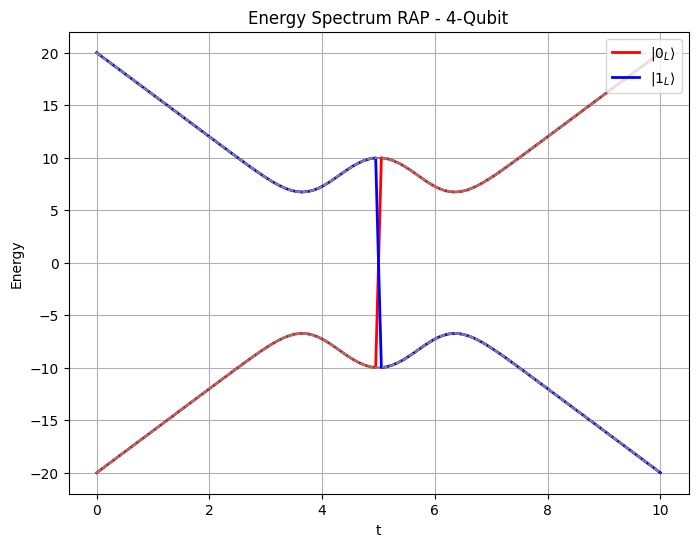

In [29]:
# Calculate the initial Hamiltonian eigenstates
H_S_0 = H_L(0)
eigenvalues_0, eigenstates_0 = H_S_0.eigenstates()

# Logical state overlaps initialization
logical_zero_energies = []
logical_one_energies = []
other_energies = []

# Loop through time steps
for t_step in range(len(times)):
    H_S = H_L(times[t_step])
    eigenvalues, eigenstates = H_S.eigenstates()

    # Track energies for logical states
    max_overlap_zero = 0
    max_overlap_one = 0
    zero_energy = None
    one_energy = None

    for i, state_t in enumerate(eigenstates):
        overlap_zero = np.abs(logical_zero.overlap(state_t))**2
        overlap_one = np.abs(logical_one.overlap(state_t))**2
        if overlap_zero > max_overlap_zero:
            max_overlap_zero = overlap_zero
            zero_energy = eigenvalues[i]

        if overlap_one > max_overlap_one:
            max_overlap_one = overlap_one
            one_energy = eigenvalues[i]

    logical_zero_energies.append(zero_energy)
    logical_one_energies.append(one_energy)

    # Store all other energies
    other_energies.append([eigenvalues[i] for i in range(len(eigenvalues)) if i != zero_energy and i != one_energy])

# Plotting
plt.figure(figsize=(8, 6))

# Plot logical states
plt.plot(times, logical_zero_energies, color='red', linewidth=2, label=r"$|0_L\rangle$")
plt.plot(times, logical_one_energies, color='blue', linewidth=2, label=r"$|1_L\rangle$")

# Plot all other energies
for i in range(len(other_energies[0])):
    plt.plot(times, [other_energies[t][i] for t in range(len(times))], linestyle='dashed', color='gray', linewidth=1)


# Finalize the plot
plt.xlabel('t')
plt.ylabel('Energy')
plt.title(r'Energy Spectrum RAP - 4-Qubit')
plt.legend(loc='upper right')
plt.grid()
plt.show()

[-2.82842712 -2.82842712 -2.82842712 -2.82842712 -2.82842712 -2.82842712
 -2.82842712 -2.82842712  2.82842712  2.82842712  2.82842712  2.82842712
  2.82842712  2.82842712  2.82842712  2.82842712]
Energy gap of stabilizer suppression 4.0
Energy gap of gauge suppression 5.656854249492381
0.8284271247461903


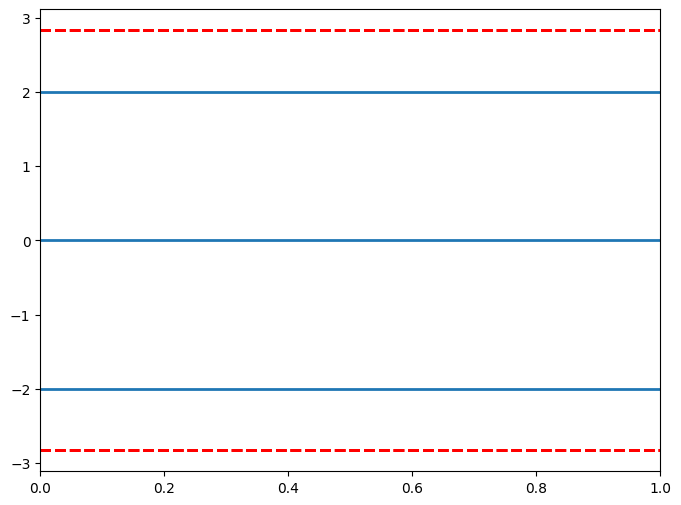

In [23]:
# Stabilizers
S_X = tensor(X, X, X, X)
S_Z = tensor(Z, Z, Z, Z)

# Gauge Operators
X_A = tensor(X, X, I, I)
Z_A = tensor(Z, I, Z, I)
lambda1 = 1
lambda2 = 1
nu1 = 1
nu2 = 1
x = 1
z = 1

H_supp_stab = S_X + S_Z
H_supp_gauge = -(lambda1 + lambda2*x) * X_A -(nu1 + nu2*z) * Z_A

energies_stab = H_supp_stab.eigenenergies()
energies_gauge = H_supp_gauge.eigenenergies()

plt.figure(figsize=(8, 6))
s_energies = []
for energy in energies_stab:
    if energy not in s_energies:
        plt.axhline(y = energy, linestyle = '-', linewidth = 2)
    s_energies.append(energy)
for energy in energies_gauge: 
    plt.axhline(y = energy, linestyle = '--', linewidth = 2, color = 'red')

print(energies_gauge)
# Calculate energy gaps
gap_stab = np.max(energies_stab) - np.min(energies_stab)
gap_gauge = np.max(energies_gauge) - np.min(energies_gauge)
print("Energy gap of stabilizer suppression", gap_stab)
print("Energy gap of gauge suppression", gap_gauge)
print(2*(np.sqrt(2) - 1))

IndexError: list index out of range

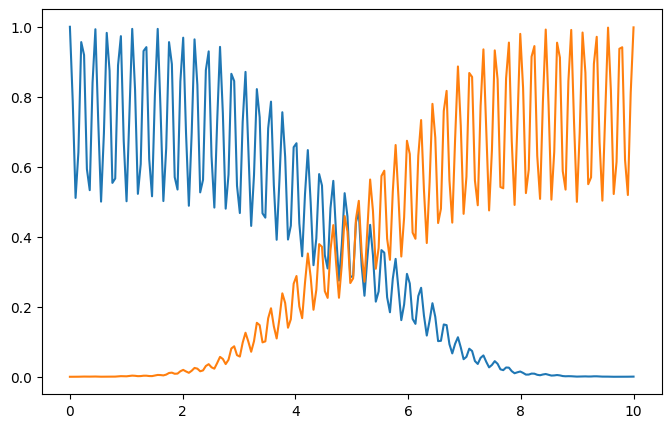

In [160]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Define Pauli Matrices
I = qt.qeye(2)  # Identity
X = qt.sigmax()
Z = qt.sigmaz()

# Logical operators in the 4-qubit space
X_L = qt.tensor(X, I, X, I)
Z_L = qt.tensor(Z, Z, I, I)

# Gauge generators (energy suppression terms)
G = [qt.tensor(X, X, I, I), qt.tensor(I, I, X, X),
     qt.tensor(Z, I, Z, I), qt.tensor(I, Z, I, Z)]

# Energy suppression term
E_P = 5  # Penalty strength
H_supp = -E_P * sum(G)

# Time evolution parameters
t_max = 10  # Evolution time
num_steps = 200
times = np.linspace(0, t_max, num_steps)

# Define omega(t) as a Gaussian with area 4pi
def omega(t, args):
    sigma = t_max / 5  # Standard deviation
    return (4 * np.pi / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((t - t_max/2) / sigma) ** 2)

# Define Delta(t) as a linear sweep from -5 to +5
def delta(t, args):
    return -5 + 10 * (t / t_max)

# Time-dependent Hamiltonian definition
H_t_list = [[X_L, omega], [Z_L, delta], H_supp]

# Initial state |0_L>
psi_0 = (qt.tensor(qt.basis(2, 0), qt.basis(2, 0), qt.basis(2, 0), qt.basis(2, 0)) +
         qt.tensor(qt.basis(2, 1), qt.basis(2, 1), qt.basis(2, 1), qt.basis(2, 1))) / np.sqrt(2)

# Target final state |1_L>
psi_1 = (qt.tensor(qt.basis(2, 1), qt.basis(2, 0), qt.basis(2, 1), qt.basis(2, 0)) +
         qt.tensor(qt.basis(2, 0), qt.basis(2, 1), qt.basis(2, 0), qt.basis(2, 1))) / np.sqrt(2)

# Solve the time evolution using QuTiP's mesolve
result = qt.mesolve(H_t_list, psi_0, times, [], [psi_0*psi_0.dag(), psi_1*psi_1.dag()])

# Plot the expectation values of X_L and Z_L
plt.figure(figsize=(8, 5))
plt.plot(times, result.expect[0], label=r'$\langle X_L \rangle$')
plt.plot(times, result.expect[1], label=r'$\langle Z_L \rangle$')
plt.plot(times, result.expect[2], label='Fidelity')
plt.xlabel("Time")
plt.ylabel("Expectation Value / Fidelity")
plt.legend()
plt.title("Rapid Adiabatic Passage Dynamics with Fidelity")
plt.show()
